In [1]:
%load_ext autoreload 
%autoreload 2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sns.set_style('white')
sys.path.insert(0, '../../')
from curve_models import NLLS_three_param, power_law_three_param, power_law_exp_three_param
from curve_models import NLLS_w, power_law
from curve_models import BrokenCurve, power_law

from tqdm.notebook import tqdm

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

expmt_dict = {'gl-tiny': '0.1_5_False_uniform_30_0.5_0.5_1880_9400_94001' + '/',
                'ml-20m-uniform': '0.1_5_False_uniform_30_0.5_0.5_20000_100000_1000001' + '/', 
                'ml-20m-tiny':'0.1_5_False_uniform_30_0.5_0.5_5250_21000_213973' + '/',
                'gl': '0.1_5_False_uniform_30_0.5_0.5_5800_29000_290001' +'/'}
dataset_name = 'gl'
dataset_names = ['gl']
step_size_expmts = ['0.1_5_False_uniform_30_0.5_0.5_1450_7250_290000', 
                         '0.1_5_False_uniform_30_0.5_0.5_2900_14500_290000', 
                         '0.1_5_False_uniform_30_0.5_0.5_5800_29000_290000', 
                         '0.1_5_False_uniform_30_0.5_0.5_8700_43500_290000', 
                        '0.1_5_False_uniform_30_0.5_0.5_11600_58000_290000', 
                        '0.1_5_False_uniform_30_0.5_0.5_14500_72500_290000', 
                        '0.1_5_False_uniform_30_0.5_0.5_17400_87000_290000', 
                        '0.1_5_False_uniform_30_0.5_0.5_20300_101500_290000', 
                        '0.1_5_False_uniform_30_0.5_0.5_23200_116000_290000', 
                        '0.1_5_False_uniform_30_0.5_0.5_26100_130500_290000', 
                        '0.1_5_False_uniform_30_0.5_0.5_29000_145000_290000']
step_sizes = [int(f.split('_')[-3])/int(f.split('_')[-1]) for f in step_size_expmts]

afa_alg = 'Random'
dataset_dict =  {'gl':'GoogleLocal-L', 'gl-tiny':'GoogleLocal-S', 
                 'ml-20m-uniform': 'MovieLens-L', 'ml-20m-tiny': 'MovieLens-S'}

alternate_slope_approx = False

In [1]:
n_runs = 5
slope_dicts = []
hue_order = ['True', 'NLS_initial', 'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'broken']
for expmt_name in tqdm(step_size_expmts):
    results_dir = "../../results/forecasting/" + dataset_name + "/" + afa_alg + "/"
    results_path = results_dir + expmt_name + '/'
    step_size = int(expmt_name.split('_')[-3])/int(expmt_name.split('_')[-1])
    all_ss = np.loadtxt(results_path + 'sample_sizes')
    all_mses = np.loadtxt(results_path + 'mses')
    data = pd.read_csv(results_path + 'results_df')
    n_init = data['n_init'].iloc[0]
    n_max = all_ss[0][-1]
    for r in range(n_runs):
        ss = all_ss[r]
        mses = all_mses[r]
        for i in range(1, len(ss)-2):
            if ss[i] < n_init:
                continue
            pct = ss[i]/n_max
            slope_before = (mses[i] - mses[i-1])/(ss[i] - ss[i-1])
            slope_after = (mses[i+1] - mses[i])/(ss[i+1] - ss[i])
            slope = .5*(slope_before+slope_after)
            if i-2 > 0 and i+2 < len(mses) and not alternate_slope_approx:
                slope = (mses[i+2] - mses[i-2])/(ss[i+2] -  ss[i-2])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'True',
                               'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})
            
            slope = (mses[i] - mses[i-1])/(ss[i] - ss[i-1])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'Naive',
                               'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})


            nlls = NLLS_w(power_law)
            stop_pt = min(np.where(ss > n_init)[0])
            nlls.fit(ss[:stop_pt], mses[:stop_pt])
            slope = nlls.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_initial',
                               'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})

            nlls_w = NLLS_w(power_law)
            nlls_w.fit(ss[:i+1], mses[:i+1])
            slope = nlls_w.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_w',
                               'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})

            nlls_3p = NLLS_three_param(power_law_three_param, "power_law_3p")
            nlls_3p.fit(ss[:i+1], mses[:i+1]) 
            slope = nlls_3p.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_power_law_3P',
                               'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})

            nlls_3p = NLLS_three_param(power_law_three_param, "power_law_3p")
            nlls_3p.fit(ss[:i+1], mses[:i+1]) 
            slope = nlls_3p.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_power_law_3P',
                               'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})

            nlls_exp_3p = NLLS_three_param(power_law_exp_three_param, "power_law_exp_3p")
            nlls_exp_3p.fit(ss[:i+1], mses[:i+1])
            slope = nlls_exp_3p.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'NLS_power_law_exp_3P', 
                               'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})

            broken = BrokenCurve(power_law, "3p-power-law")
            broken.fit(ss[:i+1], mses[:i+1])
            slope = broken.slope(ss[i])
            slope_dicts.append({'size': ss[i], 'slope': slope, 'run': r, 'cm': 'broken',
                                'dataset': dataset_name, 'pct': pct,
                               'step_size': step_size})
        #slopes.append(slope_before)
slope_df = pd.DataFrame(slope_dicts)

NameError: name 'step_size_expmts' is not defined

In [9]:
slope_df = pd.DataFrame(slope_dicts)
slope_df.to_csv('../../results/slopes_gl_' + afa_alg +'_step_size_df.csv')

In [2]:
slope_df = pd.read_csv('../../results/slopes_gl_' + afa_alg +'_step_size_df.csv')

<AxesSubplot:xlabel='pct', ylabel='slope'>

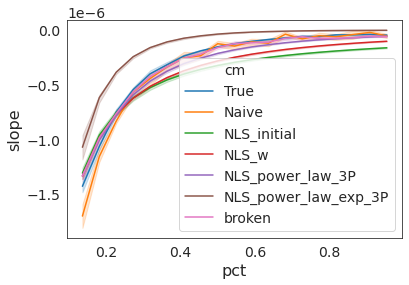

In [3]:
gg = slope_df[slope_df['step_size'] == step_sizes[5]]
sns.lineplot(x='pct', y='slope', hue='cm', data=gg)

<AxesSubplot:xlabel='pct', ylabel='slope'>

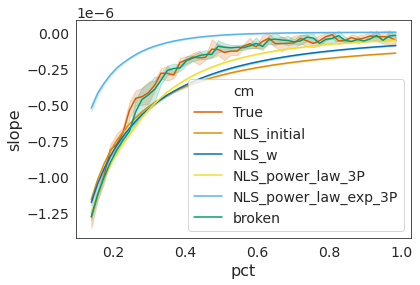

In [57]:
gg = slope_df[slope_df['step_size'] == step_sizes[2]]
sns.lineplot(x='pct', y='slope', hue='cm', data=gg)

IndexError: index 4 is out of bounds for axis 0 with size 4

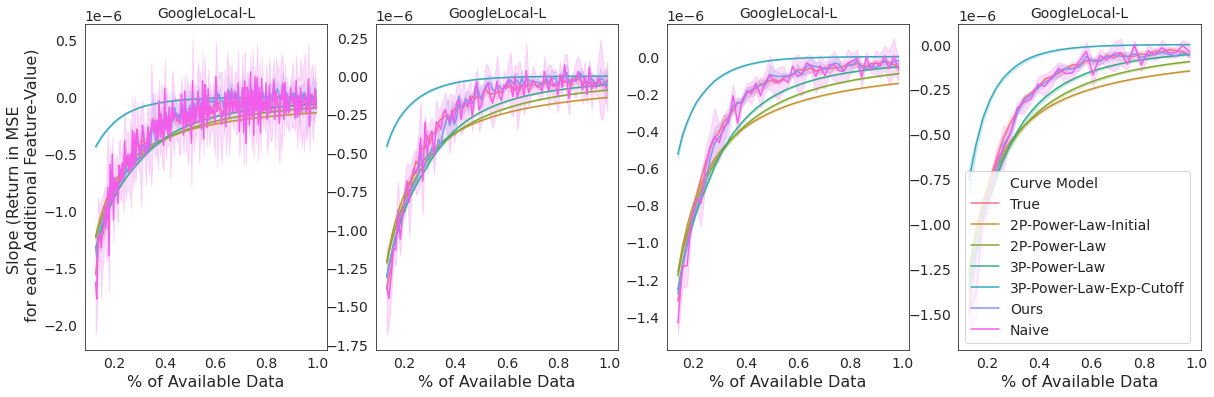

In [4]:
hue_order = ['True', 'NLS_initial', 'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'broken',
             'Naive']
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

colors = sns.color_palette("colorblind")
sns.set_palette([colors[3], colors[1], colors[0], colors[8], colors[9], colors[2]])
dataset_titles = {'gl': 'GoogleLocal-L', 'gl-tiny': 'GoogleLocal-S', 'ml-20m-tiny': 'MovieLens-S',
                 'ml-20m-uniform': 'MovieLens-L'}
for i,step_size in enumerate(step_sizes):
    if i > 4:
        continue
    ax = axs[i]
    data_df = slope_df[slope_df['step_size'] == step_size]
    sns.lineplot(x='pct', y='slope', hue='cm', hue_order=hue_order, data=data_df, 
                ax = ax)
    ax.set_xlabel("% of Available Data")
    ax.set_title(dataset_titles[dataset_name])
    if i == 0:
        ax.set_ylabel("Slope (Return in MSE \n for each Additional Feature-Value)")
    else:
        ax.set_ylabel("")
    if i != 3:
        ax.get_legend().remove()
    else:
        L=ax.get_legend()
        new_names = ['Curve Model', 'True', '2P-Power-Law-Initial', '2P-Power-Law', '3P-Power-Law', 
                     '3P-Power-Law-Exp-Cutoff', 'Ours']
        for i,new in enumerate(new_names):
            L.get_texts()[i].set_text(new)
plt.tight_layout()

all_data_dfs = slope_df

suptitle = plt.suptitle("Minimizing by Diminishing Returns: Prediction of Returns on Data", y=1.02)
plt.savefig("../../figs/diminishing_returns_fig", bbox_inches='tight',bbox_extra_artists=[suptitle])


In [ ]:
cols = ['t', 'NLS_initial',  'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'Naive', 'broken', 'True']
methods = ['NLS_initial',  'NLS_w', 'NLS_power_law_3P', 'NLS_power_law_exp_3P', 'Naive', 'broken', 'True']
final_tables = []
for step_size in step_sizes[:8]:
    # pcts collected for different thresholds
    thresholds = [-.2e-6]
    threshold_tables = []
    for t in thresholds: 
        dataset_df = slope_df[slope_df['step_size'] == step_size]
        thresh_df = dataset_df[dataset_df['slope'] > t]
        t_df = thresh_df.groupby(['run', 'cm']).first().reset_index()
        t_df['t'] = t
        t_df['dataset'] = dataset_name
        threshold_tables.append(t_df)
    threshold_table_df = pd.concat(threshold_tables)
    
    # create table of means + stds over runs
    table_df = threshold_table_df.pivot(index=['t', 'run'], columns='cm', values='pct').reset_index()
    table_df = table_df.fillna(1)

    table_df_means = table_df.groupby(['t']).mean().reset_index()
    table_df_stds = table_df.groupby(['t']).std().reset_index()
    for col in methods:
        table_df_means.rename(columns={col: col+'|mean'}, inplace=True)
        table_df_stds.rename(columns={col: col+'|std'}, inplace=True)
    table_df_means = table_df_means.reset_index()

    table_df_stds = table_df_stds.reset_index()
    table_df_means_stds = table_df_means.merge(table_df_stds, on='t')

    # turn into latex-ready table with strings
    for method in methods:
        mean_key = method + '|mean'
        std_key = method + '|std'    
        mean_values = table_df_means_stds[mean_key].round(4).map('{:.2f}'.format)
        std_values = table_df_means_stds[std_key].round(4).map('{:.2f}'.format)
        table_df_means_stds[method] = '$' + mean_values +  ' ± ' + std_values + "$"
    final_table = table_df_means_stds[cols]
    
    # Clean up column names
    final_table_col_dict = {'t': 'Threshold', 'NLS_initial': '2P-PL-Initial',  'NLS_w': '2P-PL', 'NLS_power_law_3P': '3P-PL', 
                   'NLS_power_law_exp_3P': '3P-PL-Exp', 'broken': 'Ours', 'True': 'True',
                           'Naive': 'Naive'}
    final_table.rename(columns=final_table_col_dict, inplace=True)
    final_table['Query Size'] = step_size
    final_tables.append(final_table)
final_tables_df = pd.concat(final_tables)

In [ ]:
def rewrite_e_notation(input_str):
    if '.' not in input_str:
        input_str =  input_str[:2] + '.0' + input_str[2:]
    return input_str
final_tables_df['Threshold'] = final_tables_df['Threshold'].astype(str).apply(rewrite_e_notation)
final_col_order = ['Query Size', 'Threshold', '2P-PL-Initial',   '2P-PL', 
                   '3P-PL', '3P-PL-Exp', 'Naive', 'Ours', 'True']
final_tables_df = final_tables_df[final_col_order]
final_tables_df = final_tables_df.sort_values(by=['Threshold'])
latex_string = final_tables_df.to_latex(escape=False,  index=False,
                                        column_format='c|c|ccccccc')
latex_string = latex_string.replace('±','\pm')
print(latex_string)

# Single threshold figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


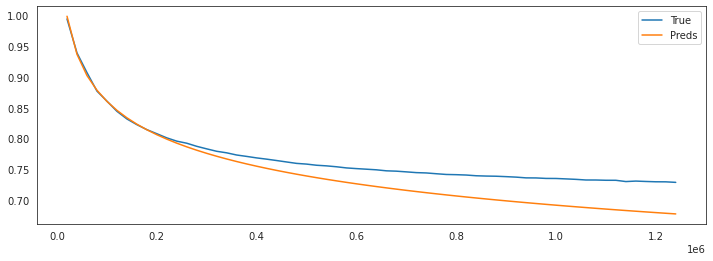

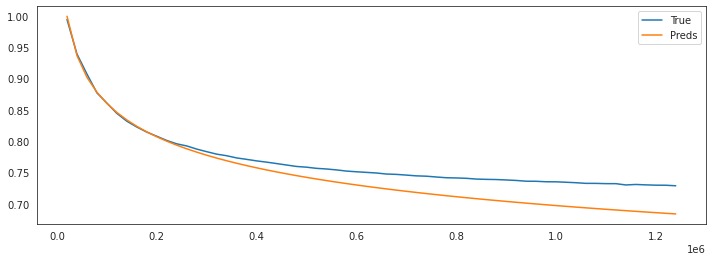

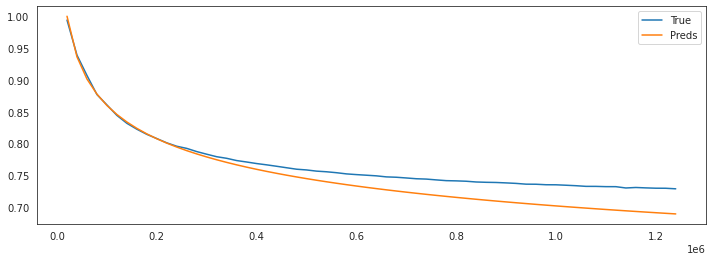

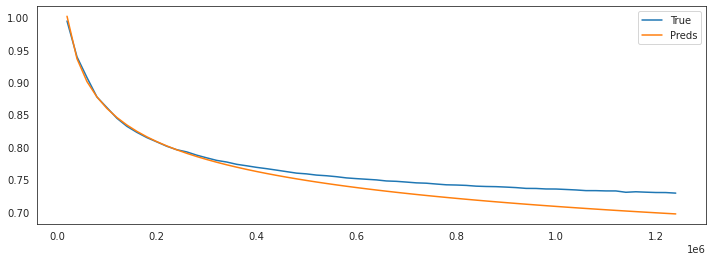

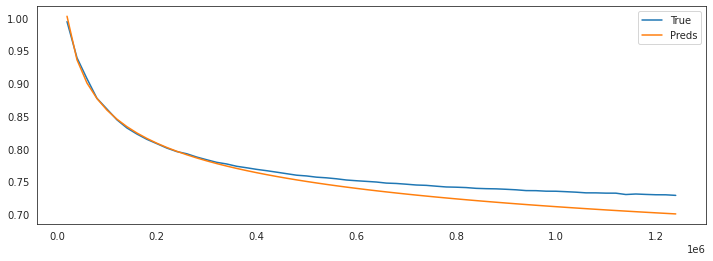

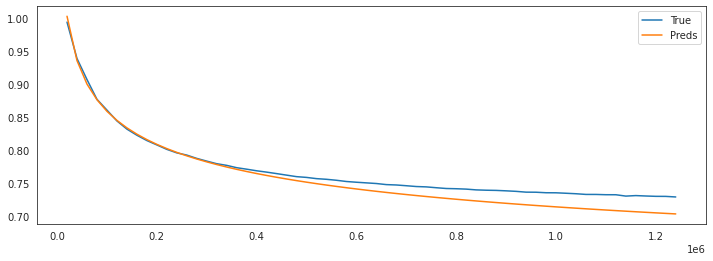

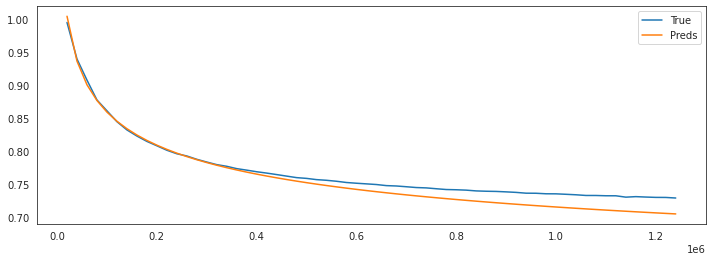

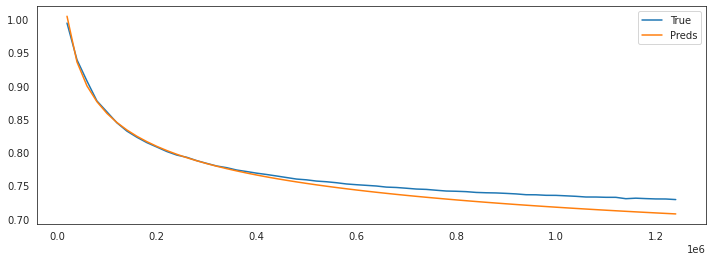

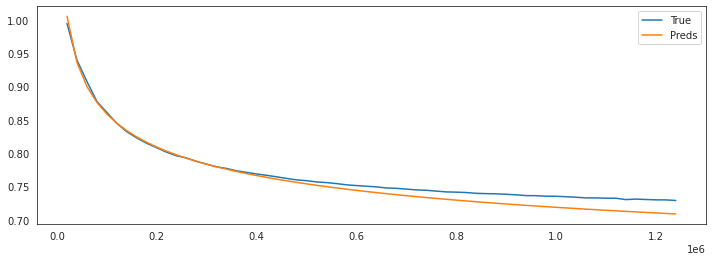

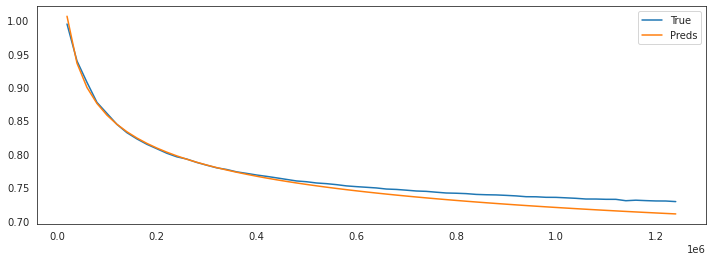

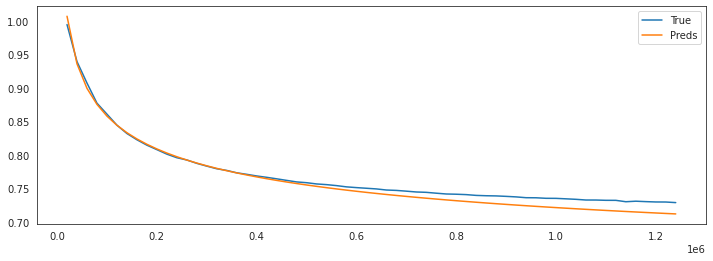

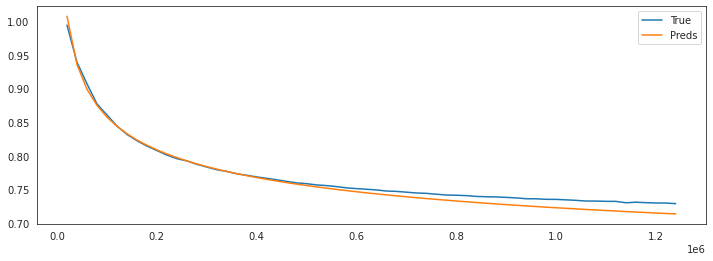

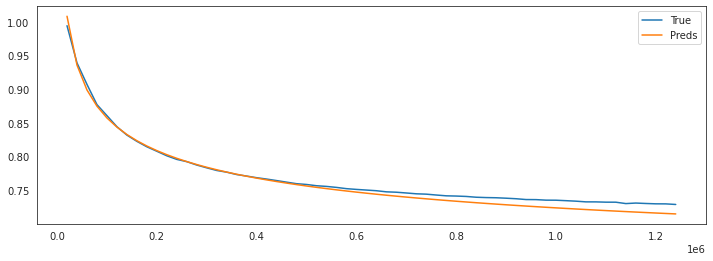

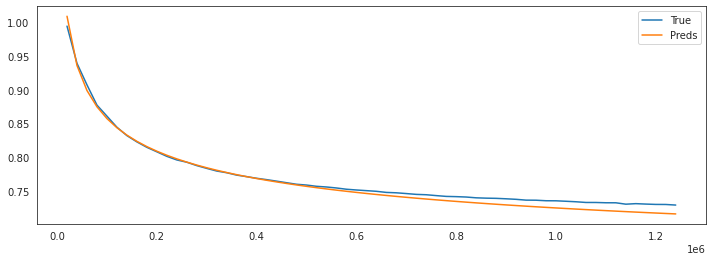

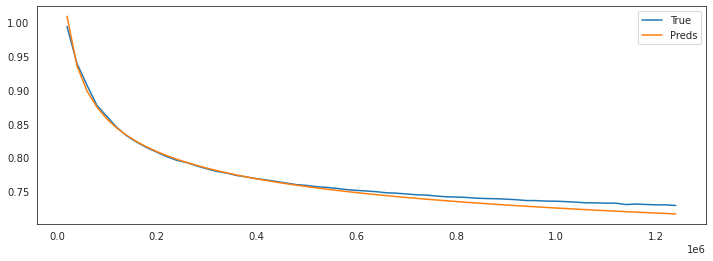

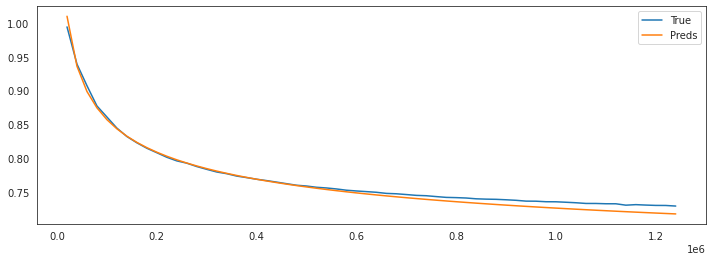

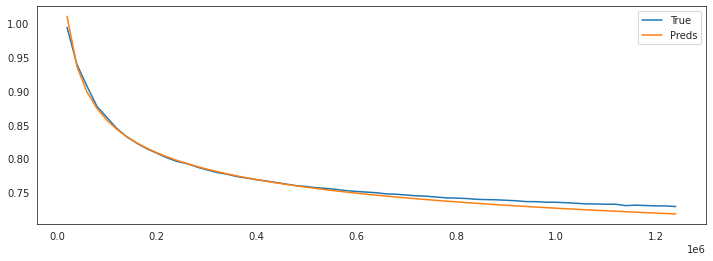

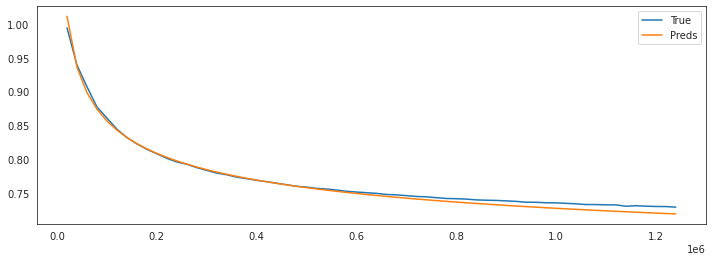

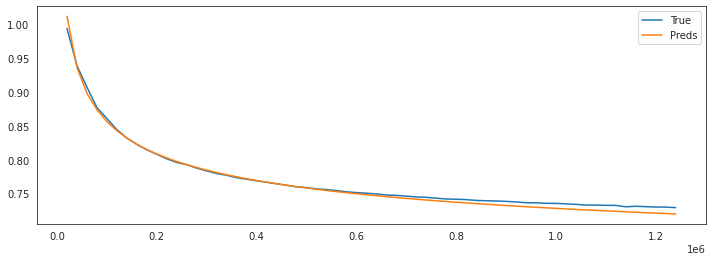

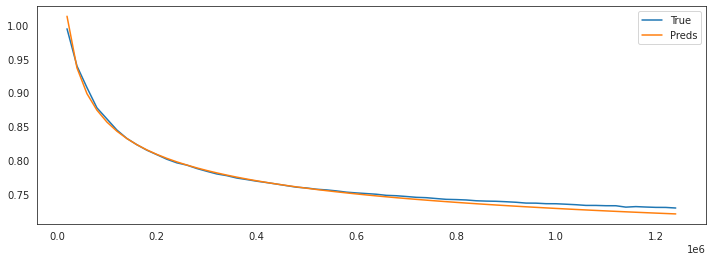

In [11]:
best_preds = []
for run in [2]:
    best_preds.append([])
    for n_obs in list(np.arange(10,30)):
        ss = all_ss[run]
        mses = all_mses[run]
        #nlls_3p = BrokenCurve(power_law, "power_law_exp")
        nlls_3p = NLLS_three_param(power_law_three_param, "3p-power-law")
        #nlls_3p = BrokenCurve(power_law, "broken_power_law")
        nlls_3p.fit(ss[:n_obs], mses[:n_obs])

        # print(nlls_3p.p)

        plt.figure(figsize=(12, 4))
        plt.plot(ss, mses, label='True')
        preds = [nlls_3p.pred(i) for i in ss]
        plt.plot(ss, preds, label='Preds')
        plt.legend()
        slopes.append(nlls_3p.slope())
#         best_preds[run].append(preds[-1])


# Statistical Significance Analyses

In [169]:
threshold_table_dfs  = []
for dataset in dataset_names:
    # pcts collected for different thresholds
    thresholds = [-.5e-6, -.4e-6, -.3e-6, -.25e-6, -.2e-6, -.15e-6,-.1e-6,-.05e-6]
    threshold_tables = []
    for t in thresholds: 
        dataset_df = all_data_df[all_data_df['dataset'] == dataset]
        thresh_df = dataset_df[dataset_df['slope'] > t]
        t_df = thresh_df.groupby(['run', 'cm']).first().reset_index()
        t_df['t'] = t
        t_df['dataset'] = dataset
        threshold_tables.append(t_df)
    threshold_table_df = pd.concat(threshold_tables)
    threshold_table_dfs.append(threshold_table_df)
threshold_table_dfs = pd.concat(threshold_table_dfs)

In [188]:
from scipy.stats import ttest_ind
dataset = 'ml-20m-tiny'
dataset_threshold_df = threshold_table_dfs[threshold_table_dfs['dataset'] == dataset]
dataset_threshold_df = dataset_threshold_df.pivot(index=['t', 'run'], columns='cm', values='pct').reset_index()
dataset_threshold_df.fillna(1, inplace=True)
baselines = ['NLS_initial', 'NLS_power_law_3P', 'NLS_w', 'NLS_power_law_exp_3P',]
for baseline in baselines:
    our_error = np.abs(dataset_threshold_df['broken'] - dataset_threshold_df['True'])
    baseline_error = np.abs(dataset_threshold_df[baseline] - dataset_threshold_df['True'])
    print(baseline, ttest_ind(our_error, baseline_error))

NLS_initial Ttest_indResult(statistic=-7.494107066084886, pvalue=8.923462621309962e-11)
NLS_power_law_3P Ttest_indResult(statistic=-7.450810173022077, pvalue=1.0809527871861969e-10)
NLS_w Ttest_indResult(statistic=-8.126117460579628, pvalue=5.360826229872694e-12)
NLS_power_law_exp_3P Ttest_indResult(statistic=-19.439389854228633, pvalue=1.2310793410944682e-31)


In [14]:
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print(R, p)

18.92314730978498
0.8389908399909444
-0.09615623738794024 0.923396487204155


In [40]:
# lognormal and exponential make more sense?
# could turn this into a prob dist so that it's actually describing the shape 

freqs = 100000* all_mses[1]/np.sum(all_mses[1])

In [41]:
freqs = [int(f) for f in freqs]

all_samples = []
for i,ss in enumerate(all_ss[1]):
    all_samples.extend([ss for j in range(freqs[i])])

In [45]:
results = powerlaw.Fit(all_samples[:60000])
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(R, p)

Calculating best minimal value for power law fit


6.721314616251052
139200.0
-85.27560890993384 0.0


In [44]:
len(all_samples)

99971